## Vegetation mapping

In this exercise you will work on a hyperspectral image.  

You will hand in a short report on the findings from each step, and attach the python code in the end.

The image is obtained from plane with a hyperspectral camera from NEO (Norsk ElektroOptikk) in the wavelength interval 400-100 nm. The image is from Sandvika and belongs to Bærum Kommune.

The file is named sandvika.npy

You will also need the header file with wavelengths for each band number called Visnir.hdr

 

1. First you need to load the image into Python, as shown in the lecture notes, there is an example python script here.

2. Write a function the defines the band number for blue (440 nm), green (535 nm), red (645 nm) and NIR (800 nm) by using the wavelength info in the  header file. 

3. Display an RGB image from the hyperspectral image and included it in your report.

4. Write a function that computes the NDVI index (Normalized Difference Vegetation Index)

      NDVI = (NIR-Red)/(NIR+Red)

5. Display the NDVI image in a sensible range and include it in  the report.

6. Select a point with 
- 1)vegetation, 
- 2)one with asphalt(pich dhalai er kalo ta) and 
- 3)one with a roof and\

plot the spectra and show them in the report.  

7. Compute and display a histogram of all the NDVI values in the image, include it in the report.

8. Make a threshold of NDVI > 0.6 and set all values with NDVI > 0.6 to zero. Display this image. What do you see ? (include in report)

9. Can you use this information to determine the  fraction area of the image that has vegetation ?

10. Carry out a principal component analysis (PCA) of the image, using the pca function from the Spectral Python.\
Study the score images  and loading plots.\
Can any of the first 3 components be used to identify vegetation in the image ? Include the **first 3 score** images and loading plots in your report.

11. Carry out a k-means clustering on a selected number of principal component score image, try k-means with 2, 3, 4 and 5 classes.  \
How many components would you chose in order to group all the pixels with vegetation ?  Include one of the k-mean calculations in the report.

12. Which method to determine the amount of vegetation do you think is most appropriate in this hyperspectral image ? Describe why you prefer one method before another.

 

Deadline is November 28th.

Good luck! 

In [95]:
# Importing all the necessary modules
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import skimage
import math


## Task1 : Loading the  image

In [44]:
hyperim = np.load("sandvika.npy")

# Task 2: Getting the bands
The function find_bands() takes a list of all the 186 wavelengths and a dictionary of required wavelengths which has band name as keys and wavelength as values. We need to find the band numbers nearest to the given required wavelengths. It returns a dictionary which has color names as keys and band number as values

In [147]:
# Function for finding the required bands
def find_bands(all_wavelengths, required_wavelengths):
    """
    Parameters:
        all_wavelengths: list of all 186 wavelengths available
        required_wavelengths:  a dictionary which has band names as keys and wavelength as values.
    Return:
        required_bands: a dictionary which has band names as keys and band number as values
    """
    required_bands = {}
    
    for wavelength in required_wavelengths.keys():
            min_distance = None
            min_wave_val = None
            band = None
            for index, wave_val in enumerate(all_wavelengths): 
                current_distance = abs(wavelength - wave_val)
                if min_distance == None:
                    min_distance = current_distance
                    min_wave_val = wave_val
                    band = index+1
                elif current_distance> min_distance:
                    break
                elif current_distance< min_distance:
                    min_distance = current_distance
                    min_wave_val = wave_val
                    band = index  

            band_name = required_wavelengths[wavelength]
            required_bands[band_name]=band        
    return required_bands

In [46]:
# Calling the function to get required wavelength bands
wavelength = envi.read_envi_header('Visnir.hdr')['wavelength']
all_wavelengths = [float(i) for i in wavelength]
required_wavelengths = {440:"blue", 535:'green', 645:'red', 800:'NIR'}
required_bands = find_bands(all_wavelengths, required_wavelengths)
print("required_bands", required_bands)

required_bands {'blue': 10, 'green': 40, 'red': 75, 'NIR': 123}


In [47]:
#Organising the RGB bands in list format
print("required_bands", required_bands)   
RGB_bands = [required_bands['red'],required_bands['green'],required_bands['blue']]
print("RGB_bands", RGB_bands)
NIR_band = required_bands['NIR']
print("NIR_band", NIR_band)
red_band = required_bands['red']
print("red_band", red_band)

required_bands {'blue': 10, 'green': 40, 'red': 75, 'NIR': 123}
RGB_bands [75, 40, 10]
NIR_band 123
red_band 75


# Task3 Displaying the RGB Image:
#### Diplaying RGB image with only 1 band for each color

With the detected band numbers for red, green and blue, an RGB image was comptuded by adding those numbers according to the respective color channels.

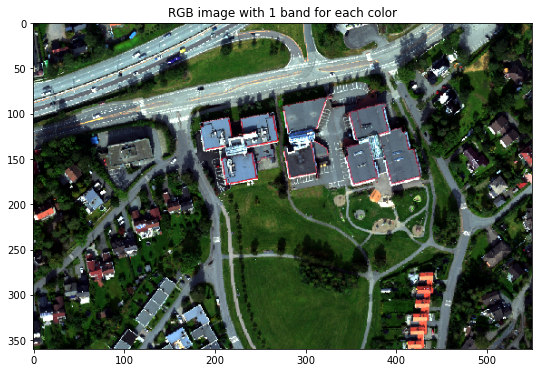

In [48]:
imshow(hyperim, bands = RGB_bands, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,6))
plt.title("RGB image with 1 band for each color")
plt.show()

#### Diplaying RGB image with an average of range of bands (10 bands) for each color
Since each color might belong to a range of bands, thus an average of close 10 bands have been taken.

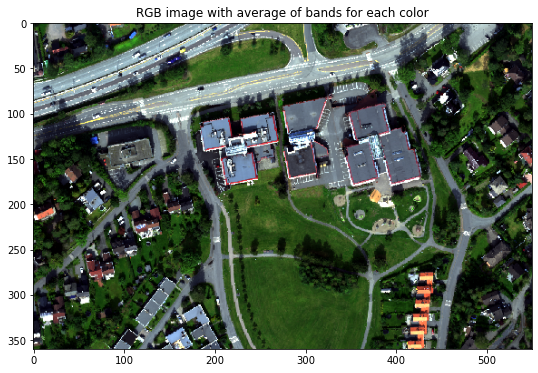

In [49]:
RGB_average_hyperim = hyperim[:, :, :]

blue_avg = RGB_average_hyperim [:, :, 10:20 ].mean(axis=2)
green_avg = RGB_average_hyperim [:, :, 40:50 ].mean(axis=2)
red_avg = RGB_average_hyperim [:, :, 65:75 ].mean(axis=2)

shape = RGB_average_hyperim.shape
RGB_avg = np.zeros([shape[0], shape[1], 3])
RGB_avg[:, :, 0] = red_avg
RGB_avg[:, :, 1] = green_avg
RGB_avg[:, :, 2] = blue_avg

imshow(RGB_avg, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,6))
plt.title("RGB image with average of bands for each color")
plt.show()

#### Comment on the RGB image with 1 band and the RGB image with the average of bands.
Each of the color belongs to multiple bands, so instead of taking just 1 band, if we take a range of bands(10 bands) belonging to that color, the image quality is improved.

# Task4- NDVI Index calculation

4. Write a function that computes the NDVI index (Normalized Difference Vegetation Index)

      NDVI = (NIR-Red)/(NIR+Red)

#### NDVI calculating using the equation/formula

In [50]:
# NDVI calculating using the equation/formula
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_manual = (hyperim[:,:,NIR_band]-hyperim[:,:,red_band])/(hyperim[:,:,NIR_band]+hyperim[:,:,red_band])

#### NDVI calculating using the python function

In [51]:
# NDVI calculating using the python function 
np.seterr(invalid='ignore') #ignoring the Nan values
ndvi_image_python = ndvi(hyperim[:,:],red_band, NIR_band)

# Task5- NDVI Image
Display the NDVI image in a sensible range and include it in  the report.

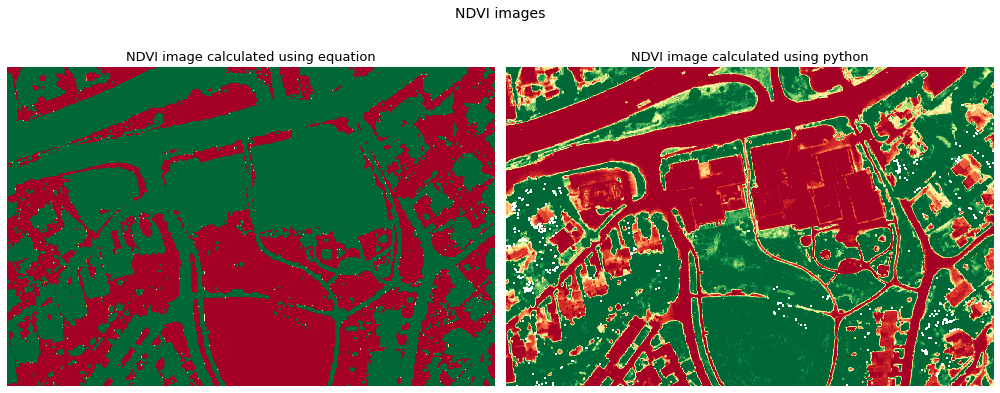

In [138]:
import matplotlib.colors as colors
# Plotting the NVDI images
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
fig.suptitle("NDVI images", fontsize = 14)

# NDVI image calculated using equation
ax[0].imshow(ndvi_image_manual,vmin=0.1,vmax=0.8, cmap='RdYlGn') 
ax[0].set_title("NDVI image calculated using equation", fontsize = 13)


# NDVI image calculated using python
ax[1].imshow(ndvi_image_python,vmin=0.1,vmax=0.8, cmap='RdYlGn') 
ax[1].set_title("NDVI image calculated using python", fontsize = 13)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

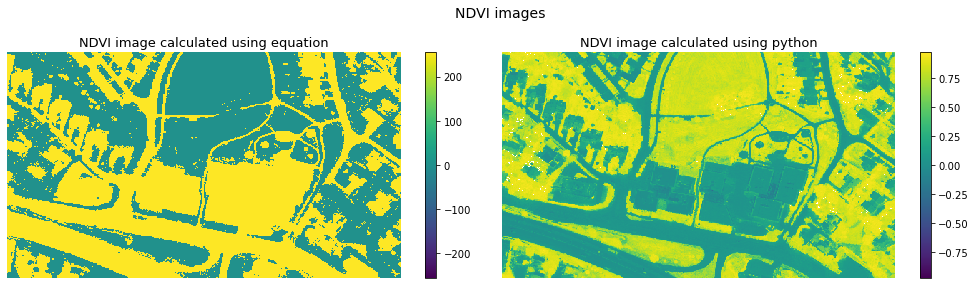

In [144]:
import matplotlib.colors as colors
# Plotting the NVDI images
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 4))
fig.suptitle("NDVI images", fontsize = 14)

# NDVI image calculated using equation

pc = ax[0].pcolormesh(ndvi_image_manual, norm=colors.CenteredNorm())
fig.colorbar(pc, ax=ax[0])
ax[0].set_title("NDVI image calculated using equation", fontsize = 13)

# NDVI image calculated using python
ax[1].set_title("NDVI image calculated using python", fontsize = 13)
pc = ax[1].pcolormesh(ndvi_image_python, norm=colors.CenteredNorm())
fig.colorbar(pc, ax=ax[1])

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


#### Comment on the NDVI Image

- NDVI index is from -1 to 1. Starting from NDVI 0.3, everything is considered to be vegetation. Different plants have different NDVI depening on their health. Extremely healthy plants with high chlorophyll will have NVDI 1. Everything that have a NDVI below 0.3 is almost a dead plant with low Chlorophyll level or an object.
- From the images above, we can see that all the vegetation has been displayed in green and rest in red.
- NDVI value calculated in both both ways using the python built-in function and formula are same.


# Task6: Spectra image

Select a point with

- 1)vegetation,
- 2)one with asphalt(pich dhalai er kalo ta) and
- 3)one with a roof and\
- plot the spectra and show them in the report.

## Spectra image with points (vegetation, asphalt and roof) 

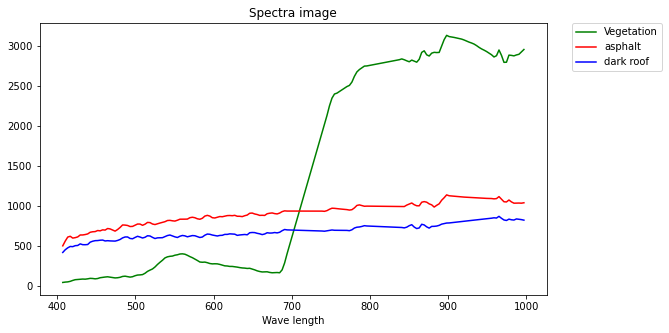

In [53]:
vegetation = np.array(hyperim[278,245,:].reshape(-1,1)) # grass
asphalt = np.array(hyperim[79,157,:].reshape(-1,1))#asphalt light
roof_dark = np.array(hyperim[99,280,:].reshape(-1,1)) # roof dark

fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

ax_dict['bottom'].plot(all_wavelengths,  vegetation, color = 'g', label='Vegetation')
ax_dict['bottom'].plot(all_wavelengths, asphalt,color = 'r', label='asphalt')
ax_dict['bottom'].plot(all_wavelengths, roof_dark,color = 'b',label='dark roof')
# Place a legend to the right of this smaller subplot.
ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("Spectra image")
plt.xlabel("Wave length")
# plt.ylabel("Pixel count")
plt.show()

#### Comment on the Spectra image
- We know the Red color has the wave length from 620 to 720 nm, the Green color has the wave length from 490 to 575 nm  and NIR has wavelength from 800 to 2,500 nm. (Source: https://www.en.silicann.com/blog/post/wavelength-color/)
Usually anything that has a higher presense in the wavelength starting after red(720nm) and before NIR(800nm) are considered vegetation.

- From the spectrum image, we can see that 
  - Both asphalt and roof has very flat length, without any spikes in the vegetation considered wavelength zone.  
  - Grass(vegatation) has a spike from approximately 680nm which continued till the end, proving the presense of chlorophyll in that range of wavelength. 
  - Small peak in the Green color wavelength zone (490 to 575 nm), justifies the vegetation reflecting green lights.


## Mean spectrum of 20x20 pixels for each material/region

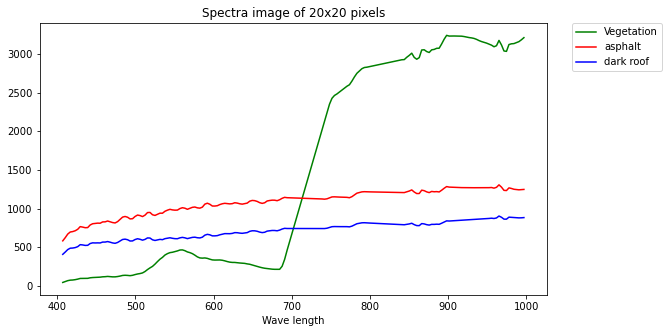

In [54]:
vegetation1 = hyperim[290:310, 275:295,:].mean(axis=0) # grass
vegetation = vegetation1.mean(axis=0).reshape(-1,1) # grass

asphalt1 = hyperim[85:105, 150:170,:].mean(axis=0) # asphalt
asphalt = asphalt1.mean(axis=0).reshape(-1,1) # asphalt

roof_dark1 = hyperim[90:110, 300:320,:].mean(axis=0) #roof_dark1
roof_dark = roof_dark1.mean(axis=0).reshape(-1,1) # roof_dark1


fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

ax_dict['bottom'].plot(all_wavelengths,  vegetation, color = 'g', label='Vegetation')
ax_dict['bottom'].plot(all_wavelengths, asphalt,color = 'r', label='asphalt')
ax_dict['bottom'].plot(all_wavelengths, roof_dark,color = 'b',label='dark roof')
# Place a legend to the right of this smaller subplot.
ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("Spectra image of 20x20 pixels")
plt.xlabel("Wave length")
plt.show()

#### Comment on the Mean spectrum of 20x20 pixels for each material/region
- From the mean spectrum of 20x20 pixels, we can see that both asphalt and roof has very flat length, without any spikes in the vegetation considered wavelength zone. On the other hand, grass(vegatation) has a spike from approximately 680nm which continued till the end, proving the presense of chlorophyll in that range of pixels.

#### Comment on the Spectra image with points vs  Mean spectrum of 20x20 pixels for each region
*Spectra image with just points* and *Spectra image with 20x20 pixels* does not have any visible drastic changes, rather they look same. It implies the range of pixels belonged to almost similar colors.

## Mean spectra image with the average of 3 points (vegetation, asphalt and roof)

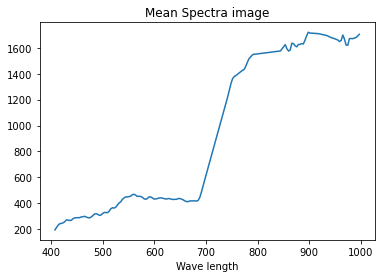

In [55]:
#compute mean of all spectra
avg_spectra1 = hyperim.mean(axis=0)
avg_spectra2 = avg_spectra1.mean(axis=0).reshape(-1,1)
plt.figure()
plt.title("Mean Spectra image")
plt.xlabel("Wave length")
plt.plot(all_wavelengths, avg_spectra2 )
plt.show()

#### Comment on the Mean spectra image with the average of 3 points
- The spectral of the vegetation dominates the mean spectra, because the vegetaion ratio in this image is comparatively greater than the rest.

# Task7 histogram of all the NDVI
Compute and display a histogram of all the NDVI values in the image, include it in the report.\




##### Facts about the NDVI valus:
- High values (0.66 to 1) represent very healthy plants
- Moderate values (0.33 to 0.66 ) represent moderately healthy plants
- Very low values of NDVI (0.1 and below) correspond to barren areas of rock, sand, or snow. Negative values are often water.
- Source link: https://earthobservatory.nasa.gov/features/MeasuringVegetation

#####  Comment on the Histogram
From the histogram, we can see that -
- from (-0.1 to 0.19), we can see a peak in the pixel count which represents roads, roof tops and other objects found in the image.
- from (0.2 to 0.3), there are few pixel counts. So very few moderately healthy plants present in the image.
- from (0.7 to 0.9), we can see a peak in the pixel count which represents high number of healthy vegetation found in the image.


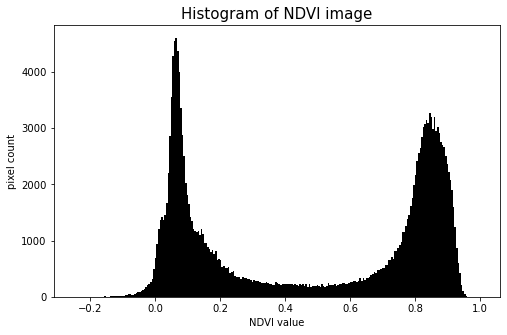

In [56]:
# Creating histogram using matplot_lib
plt.figure(figsize=(8,5))
plt.hist(ndvi_image_manual.ravel(),bins=256, range=[-0.25,1], color='black')
plt.title("Histogram of NDVI image", fontsize=15)
plt.xlabel("NDVI value")
plt.ylabel("pixel count")
plt.show()

In [57]:
# # Creating histogram using numpy
# histogram, bin_edges = np.histogram(ndvi_image_manual, bins=256, range=(-.25, 1))
# plt.figure(figsize=(8,5))
# plt.title("Histogram of NDVI image")
# plt.xlabel("NDVI value")
# plt.ylabel("pixel count")
# plt.xlim([-0.25, 1.0])  
# plt.plot(bin_edges[0:-1], histogram)  
# plt.show()

# Task8 Thresholding NDVI
Make a threshold of NDVI > 0.6 and set all values with NDVI > 0.6 to zero. Display this image. What do you see ? (include in report)

# Task9: Findig vegetation from the image
Can you use this information to determine the fraction area of the image that has vegetation ?


### Comment on Thresholed NDVI image

- We know from the NDVI 0.33, everything is considered vegetation. High values (0.66 to 1) represent very healthy plants and moderate values (0.33 to 0.66 ) represent moderately healthy plants. 

- We have set the threholding value to 0.6 which means we only want to see the **healthy vegetation**.  

- All the healthy vegetation of the image is black and rest of the elements of the image is white.

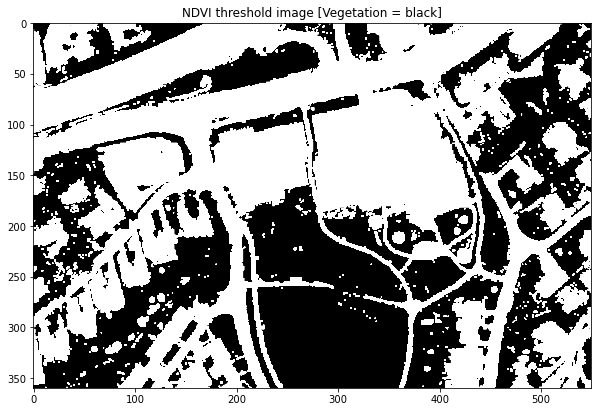

In [58]:
#Thresholding NDVI
threshold = 0.6 
ndvi_image_manual[ndvi_image_manual > threshold] = 0
ndvi_image_manual[ndvi_image_manual != 0] = 255

#Displaying the NDVI image
plt.subplots(1,1,figsize=(10,8))
plt.imshow(ndvi_image_manual,vmin=0,vmax=1, cmap='gray') 
plt.title("NDVI threshold image [Vegetation = black]")
plt.show()

In [90]:
total = ndvi_image_manual.size 
non_veg = np.count_nonzero(ndvi_image_manual) 
veg = (total - non_veg)
veg_per = ((veg*100)/total)
print("Total", total)
print("Non-vegetation", non_veg)
print("Vegetation", veg)
print(f'Fraction of vegetation is {round(veg_per, 3)}')

Total 198000
Non-vegetation 99269
Vegetation 98731
Fraction of vegetation is 49.864


# Task10 
10. Carry out a principal component analysis (PCA) of the image, using the pca function from the Spectral Python.\
Study the score images  and loading plots.\
Can any of the first 3 components be used to identify vegetation in the image ?\
Include the **first 3 score** images and loading plots in your report.



## PCA plot and PCA image

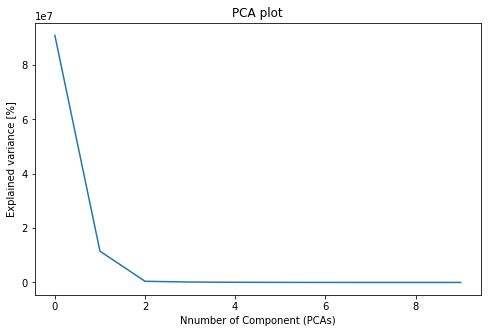

In [59]:
# Generating PCA plot to explain the variance present in the image
pc = principal_components(hyperim)
plt.figure(figsize=(8,5))
plt.plot(pc.eigenvalues[0:10])
plt.title("PCA plot")
plt.xlabel('Nnumber of Component (PCAs)')
plt.ylabel('Explained variance [%]')
plt.show()

#### Comment on the PCA plot:
- From the PCA plot, we can see that, according to the **"Elbow method"**, only the **1st three PCAs** are enough to explain the variance present in the image. But, there is a possibility that the rest of the PCAs might have important informations. So, at first we will take 6 PCAs to check whether they contain any relevant information.

### PCA image calcualtion using 6 PCs

Number of PCA's selected 6


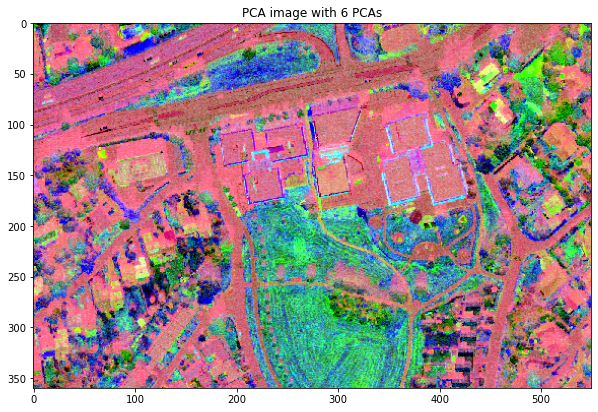

In [60]:
# PCA image calculation using 6 PCs
pc_09993 = pc.reduce(fraction=0.9993)# select the PCs with 99.93% variance-
img_6PCs = pc_09993.transform(hyperim) # then transforming that PCs with 99.93% to image
print("Number of PCA's selected", img_6PCs.shape[2])
imshow(img_6PCs, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,8), title ='PCA image with 6 PCAs')
plt.show()

# finding max and min pixel value of a image

In [61]:
# #finding max and min pixel value of a image
# smallest = np.amin(img_6PCs[:,:,5])
# biggest = np.amax(img_6PCs[:,:,5])
# print("smallest ", smallest )
# print("biggest", biggest)

In [62]:
# plt. imshow(img_6PCs[:,:,5], vmin = -1000, vmax = 2000)

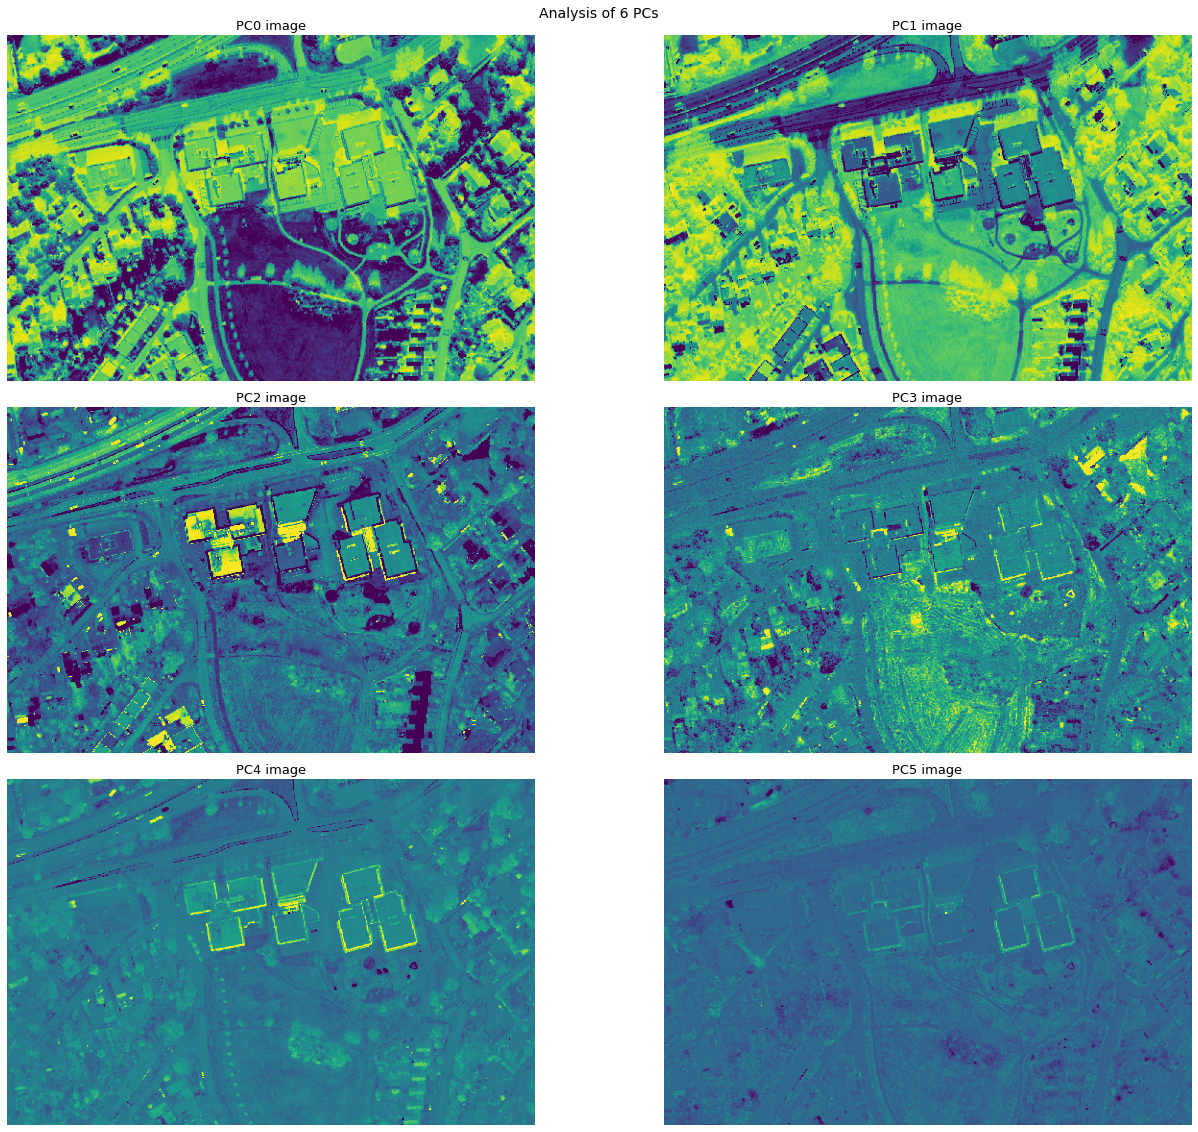

In [63]:
#Score plots with 6 PCs (99.93% variance explained)
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 16))
fig.suptitle("Analysis of 6 PCs", fontsize = 14)

ax[0, 0].imshow(img_6PCs[:,:,0], vmin=-14629, vmax=14646)
ax[0, 0].set_title(r'PC0 image', fontsize = 13)

ax[0, 1].imshow(img_6PCs[:,:,1], vmin=-6025, vmax=4065)
ax[0, 1].set_title(r'PC1 image', fontsize = 13)

ax[1, 0].imshow(img_6PCs[:,:,2], vmin=-500, vmax=1000)
ax[1, 0].set_title(r'PC2 image', fontsize = 13)

ax[1, 1].imshow(img_6PCs[:,:,3], vmin=-1000, vmax=1200)
ax[1, 1].set_title(r'PC3 image', fontsize = 13)


ax[2, 0].imshow(img_6PCs[:,:,4], vmin = -1000, vmax = 1400)
ax[2, 0].set_title(r'PC4 image', fontsize = 13)

ax[2, 1].imshow(img_6PCs[:,:,5], vmin = -1000, vmax = 2000)
ax[2, 1].set_title(r'PC5 image', fontsize = 13)

for row in ax:
    for col in row:
        col.axis('off')

fig.tight_layout()
plt.show()

##### Analysis of the PCA score plot images (99.93% variance explained)
- PC0 image differentiates 2 groups (grass and rest)
- PC1 image differentiates 3 groups (roads, roof tops and vegetation)
- PC2 image differentiates 3 groups (blue roof tops, red roof tops and rest). Few healthy grass indentified in lemon green color. 
- PC3 image has identied the shadows present in the image **[Not revelant]**
- PC4 image has identied the red border of the roof tops **[Not revelant]**
- PC5 image has identied small blue objects present in the image **[Not revelant]**

After analysis of the PCA score images, I have understood that the **1st 3 PCs has relevant information related to the detection of the vegetation**. So I will take 3 Pcs suggested by the the elbow rule.

### PCA image calcualtion using 3 PCAs

Number of PC's selected 3


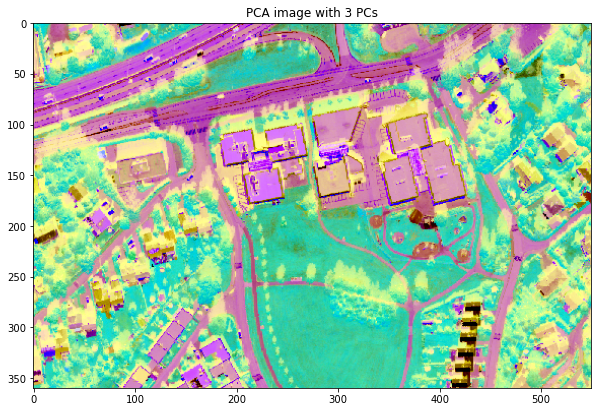

In [64]:
# # PCA image calculation using 3 PCs
pc_0997 = pc.reduce(fraction=0.997)# select the PC with 99.7% variance-
img_3PCs = pc_0997.transform(hyperim) # then transforming that PC with 99.7% to image
print("Number of PC's selected", img_3PCs.shape[2])
imshow(img_3PCs, stretch=((0.02,0.98),(0.02,0.98),(0.02,0.98)), figsize=(10,8), title ='PCA image with 3 PCs')
plt.show()

#### Comment on the PCA image:
- From the PCA image, we can see that the grassland has been represented in the 'lemon green' and the trees have been represented in the 'cyan'. So, this PCA image can successfully identify the vegetation present in the image
- No misidentification / grouping has been detected

In [65]:
## First 3 PCA score plots

In [66]:
# #Score plots with 3 PCAs 99.7% variance explained
# fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 7))
# ax[0].imshow(img_3PCs[:,:,0], vmin=-14629,vmax=14646)
# ax[0].set_title(r'PC0 image', fontsize = 13)

# ax[1].imshow(img_3PCs[:,:,1], vmin=-6025,vmax=4065)
# ax[1].set_title(r'PC1 image', fontsize = 13)

# ax[2].imshow(img_3PCs[:,:,2], vmin=-500,vmax=1000)
# ax[2].set_title(r'PC2 image', fontsize = 13)


# for a in ax:
#     a.axis('off')

# fig.tight_layout()
# plt.show()

In [67]:
# # Understaing the loading plots
# loadings corresponds to wavelenths. By looking at the wavelengths, we can understand which wavelengths have been given the weights for generating that score image


In [68]:
# # loadings
# loadings = pc_0997.eigenvectors 

# #plotting the graph
# fig, ax_dict = plt.subplot_mosaic([ ['bottom', 'BLANK']], empty_sentinel="BLANK", figsize = (20, 5))

# ax_dict['bottom'].plot( loadings[:,[0]], color = 'g', label='PC0')
# ax_dict['bottom'].plot( loadings[:,[1]], color = 'r', label='PC1')
# ax_dict['bottom'].plot( loadings[:,[2]], color = 'b', label='PC2')

# # Place a legend to the right of this smaller subplot.
# ax_dict['bottom'].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# plt.title('Loading plot')
# plt.xlabel('Band number')
# # plt.ylabel("Pixel count")
# plt.show()

In [69]:
# ##### Comment on the loading plot images
# - PC0: vegetation (mainly grass)
# - PC1: roads and roof tops
# - PC3: shadows, small details and green trees


## Interpretation of the First 3 PCA score images with their corresponding loading plots
loadings corresponds to wavelenths. By looking at the wavelengths, we can understand which wavelengths have been given the weights for generating that score image.

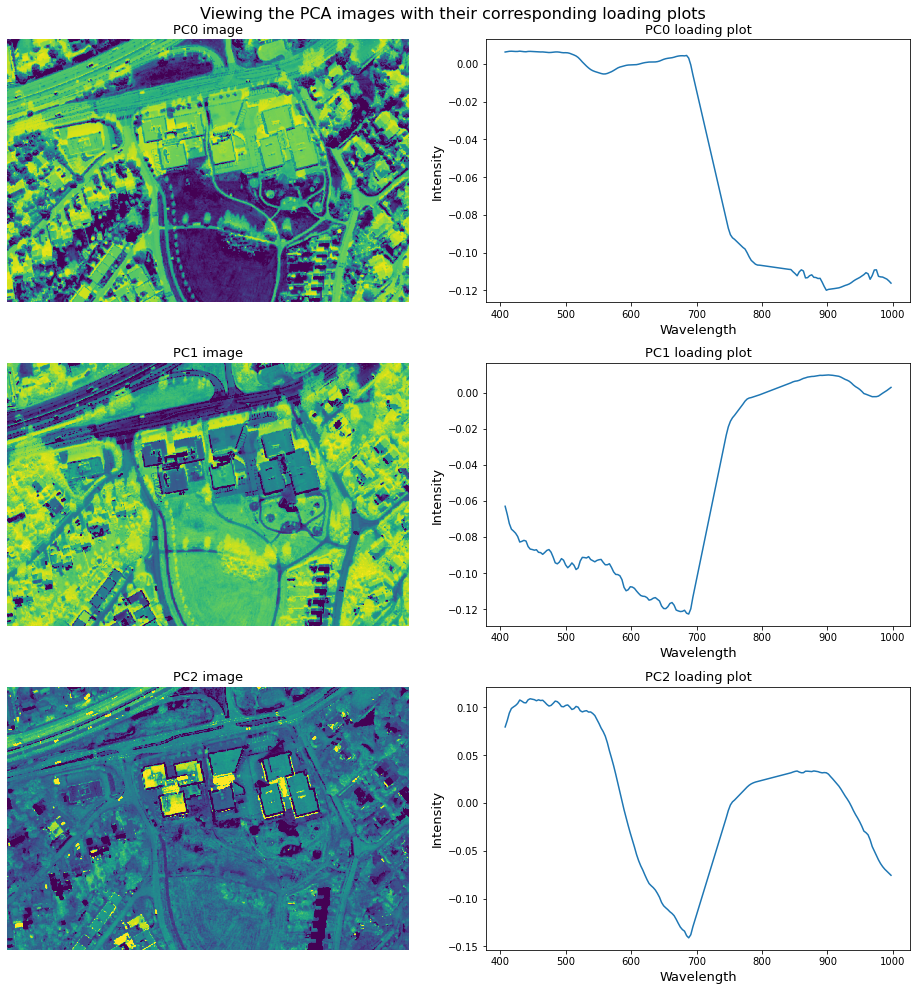

In [70]:
# loadings
loadings = pc_0997.eigenvectors 

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (13, 14)) #(width,height)
fig.suptitle("Viewing the PCA images with their corresponding loading plots", fontsize = 16)


ax[0, 0].imshow(img_3PCs[:,:,0], vmin=-14629,vmax=14646)
ax[0, 0].set_title(r'PC0 image', fontsize = 13)

ax[0, 1].plot(all_wavelengths, loadings[:,[0]])
ax[0, 1].set_title(r'PC0 loading plot', fontsize = 13)
ax[0, 1].set_xlabel('Wavelength', fontsize = 13)
ax[0, 1].set_ylabel('Intensity', fontsize = 13) 
    
    
ax[1, 0].imshow(img_3PCs[:,:,1], vmin=-6025,vmax=4065)
ax[1, 0].set_title(r'PC1 image', fontsize = 13)

ax[1, 1].plot(all_wavelengths, loadings[:,[1]])
ax[1, 1].set_title("PC1 loading plot", fontsize = 13)    
ax[1, 1].set_xlabel('Wavelength', fontsize = 13) 
ax[1, 1].set_ylabel('Intensity', fontsize = 13)     

ax[2, 0].imshow(img_3PCs[:,:,2], vmin=-500,vmax=1000)
ax[2, 0].set_title(r'PC2 image', fontsize = 13)

ax[2, 1].plot(all_wavelengths, loadings[:,[2]])
ax[2, 1].set_title(r'PC2 loading plot', fontsize = 13)   
ax[2, 1].set_xlabel('Wavelength', fontsize = 13)
ax[2, 1].set_ylabel('Intensity', fontsize = 13) 

for row in ax:
    row[0].axis('off')

fig.tight_layout()
plt.show()


#### Comment on Score images and their corresponding loading plots

- PC0: 
   - **Score image**: Differentiates 2 groups (grass and rest) which has been represented by black and green respectively.
   - **Loading plot**: Since the vegetation has been presented by the black colors in the image, a inveretd plot of the typical vegetation loading plot can be observed.

- PC1:
    - **Score image**: Differentiates 3 groups (roads, roof tops and vegetation)
    - **Loading plot**: Usually anything that has a higher presense in the wavelength starting after red(720nm) and before NIR(800nm) are considered vegetation. PC1 has identified all the vegetations(both grass and trees). A typical vegetation loading plot can be observed.

- PC2:
   - **Score image**: Differentiates 3 groups (blue roof tops, red roof tops and rest). Few healthy grass indentified in lemon green color. 
   - **Loading plot**: 
     - We know the blue color has the wave length from 420–490 nm and the Green color wavelength from 490 to 575 nm (Source: https://www.en.silicann.com/blog/post/wavelength-color/). The peak from 400 to 490, signifies the presense of "blue roof tops" identified in the image and from 490 to 575 nm signifies the reflection of green light due to vegetation presense.         
     - Small peak in the typical vegetation zone 720nm to 800nm signifies the presence of vegetation. 


# Task11
Carry out a k-means clustering on a selected number of principal component score image, try k-means with 2, 3, 4 and 5 classes.\
How many components would you chose in order to group all the pixels with vegetation ? \
Include one of the k-mean calculations in the report.

## Analysis of kmeans clustering with the PCA Image(reduced elements/noises):

In [71]:
# For stopping the spectral information printing
import logging, sys
logging.disable(sys.maxsize)

In [72]:
#Function for calculating the clusters and displaying the result images
def k_means_analysis(image, cluster_number, vmin, vmax):
    
    (m,c) = kmeans(image, cluster_number, 30) 
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
    fig.suptitle("K-means clustering with "+str(cluster_number)+" clusters", fontsize = 14)
    
#         #finding max and min pixel value of a image
#     smallest = np.amin(m)
#     biggest = np.amax(m)
#     print("smallest ", smallest )
#     print("biggest", biggest)
    
    ax[0].set_title(r'Clustering image ('+str(cluster_number)+" clusters)", fontsize = 13)
    ax[0].imshow(m, cmap ='jet', vmin = vmin, vmax= vmax)

    ax[1].set_title(r'Loading plot', fontsize = 13)
    for i in range(c.shape[0]):
        ax[1].plot(c[i])
        
    
    ax[0].axis('off')    

    fig.tight_layout()
    plt.show()

##### For k-means clustering with 2 clusters: 
- Successfully identified the grass. The grass is represented in dark blue color.

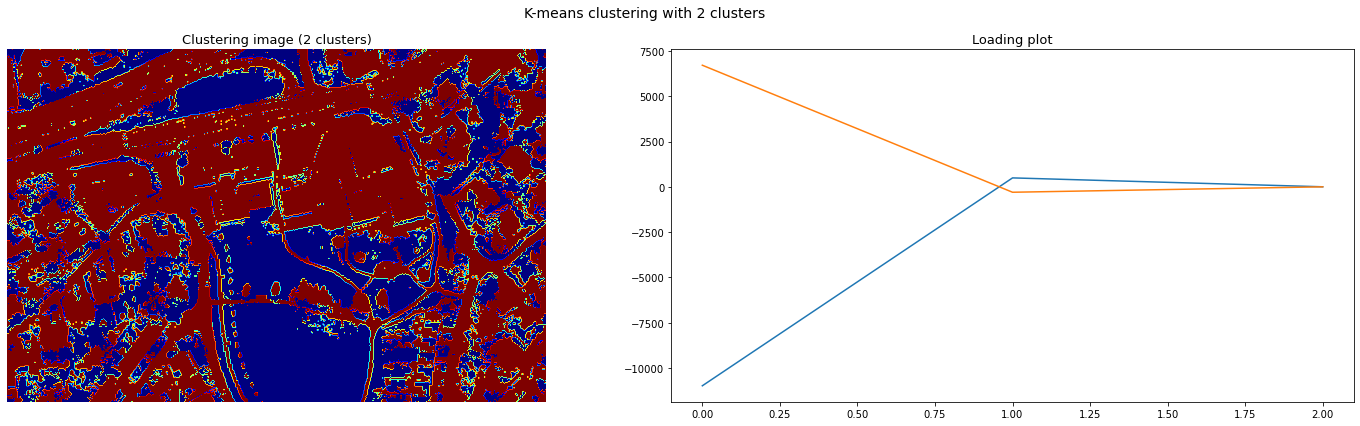

In [73]:
# 2-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_3PCs, cluster_number = 2, vmin = 0, vmax = 1)


##### For k-means clustering with 3 clusters: 
- Sucessfully identified the grass. The grass is represented in cyan color.


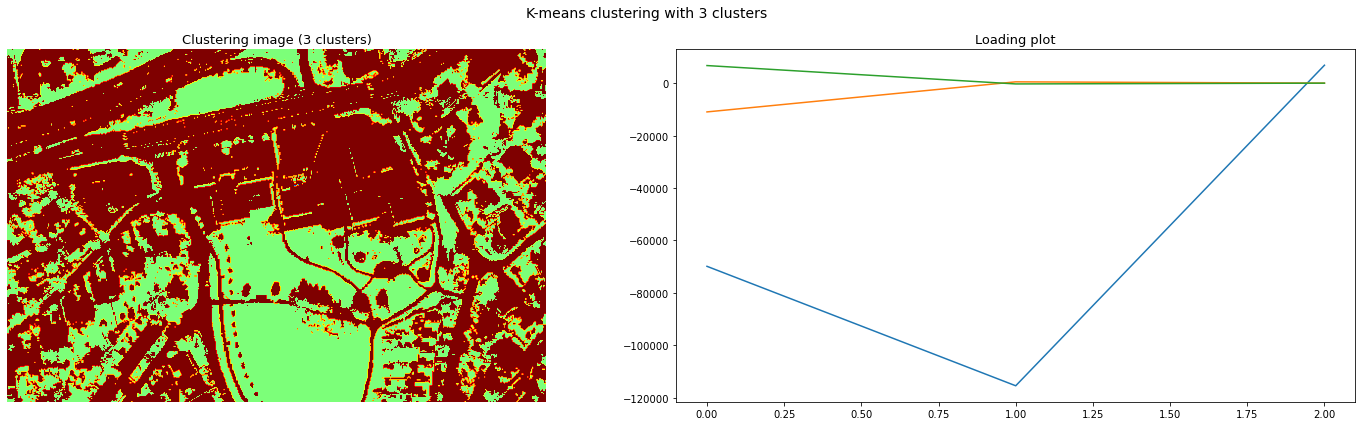

In [74]:
# 3-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_3PCs, cluster_number = 3, vmin = 0, vmax = 2)

##### For k-means clustering with 4 clusters: 
- Sucessfully identified the grass, roads and few roof tops(red & light-reflecting/shiny) present in the image. 
   - The grass is represented in yellow color. 
   - The red rooftops are represented in Cyan color.
   - the roads and concrete roof tops are represented in brown color


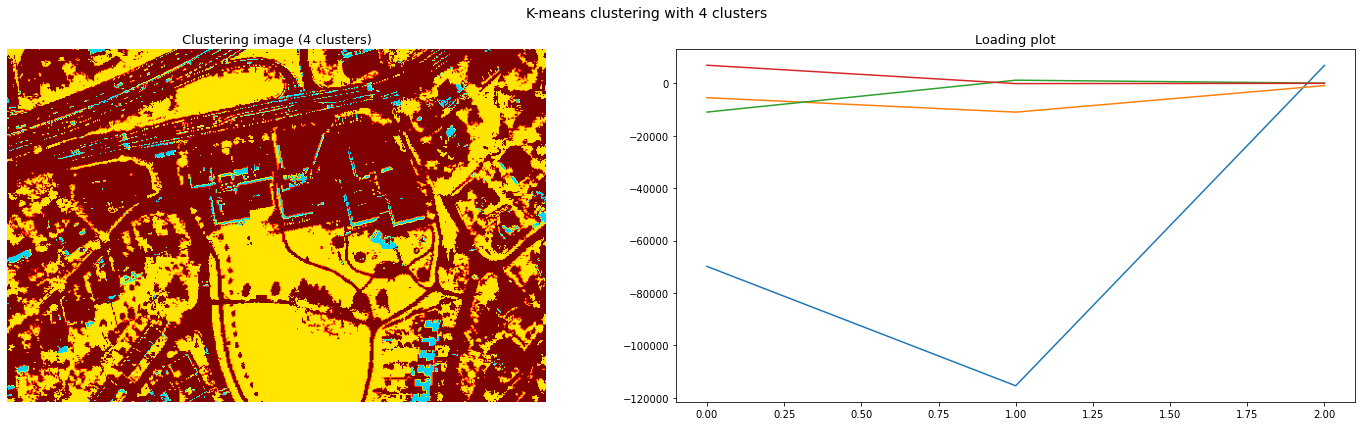

In [75]:
# 4-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_3PCs, cluster_number = 4, vmin = 0, vmax = 3)

##### For k-means clustering with 5 clusters: 
- Sucessfully identified the grass, a few roof tops, and roads present in the image. 
  - The grass has been represented in orange color. 
  - The red & light-reflecting/shiny roof tops have been represented in cyan color. 
  - The light colored roads have been represented in lime color.
  - Narrow roads and concrete roof tops have been presented in dark brown color
- **Problem:** Few of the "dark green vegetation(trees)", "narrow roads" and "concrete roof tops" have been classified in the same color/group.

**The k-means clustering with 5 clusters is the best option among the other k-means clutering options**


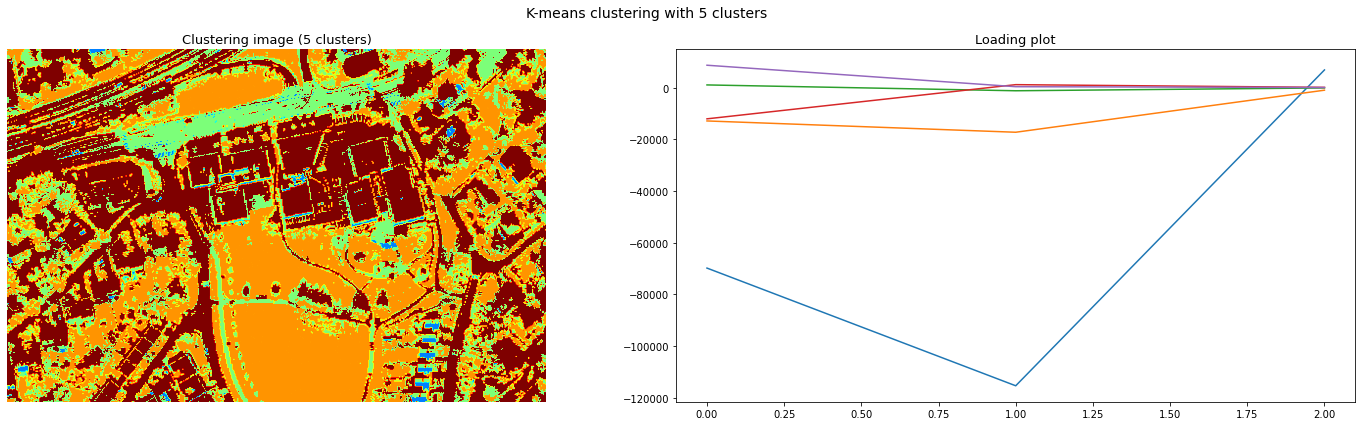

In [76]:
# 5-clusters, 30-no of iterations--On the selected PCs
k_means_analysis(img_3PCs, cluster_number = 5, vmin = 0, vmax = 4)

## Analysis of kmeans clustering with the Original Image:

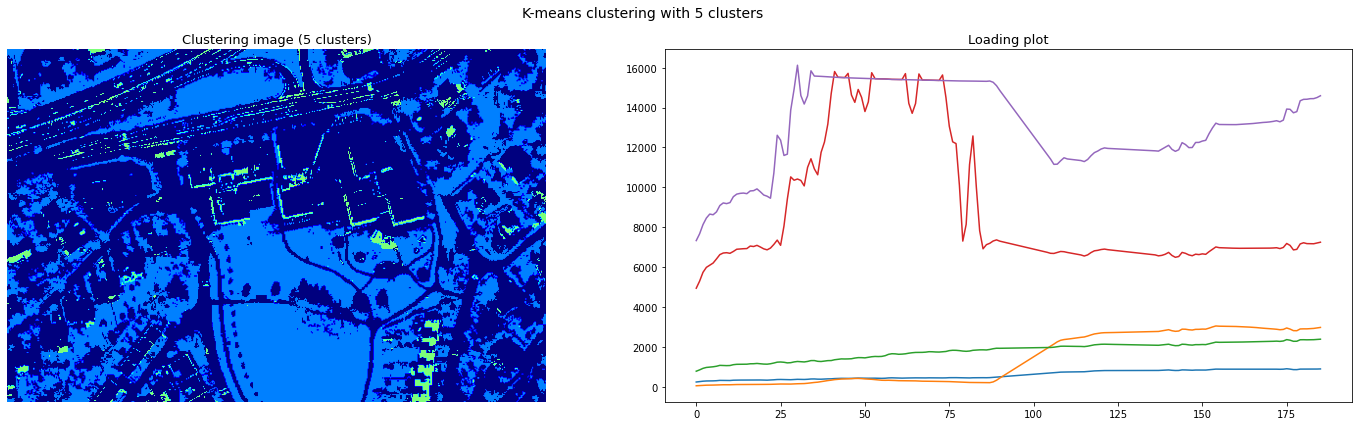

In [77]:
# 5-clusters, 30-no of iterations--On the Original image
k_means_analysis(hyperim, cluster_number = 5, vmin=0, vmax=4)

### Comment on the clustering on the original image and the loading plot.
- Sucessfully identified the grass, a few roof tops, and roads present in the image. 
  - The glass has been represented in light blue color. 
  - The red & light-reflecting/shiny roof tops have been represented in cyan color. 
  - The concrete roof tops, trees, light colored roads and few of the shadows have been represented in dark blue color. 

- **Problem:** Few of the "dark green vegetation(trees)", narrow roads and concrete roof tops have been classified in the same color/group.

### Best betweens the k-means clustering on the PCA image and the original image

- **Clustering image**:
   - Irrelevant information present in the original image, makes it impossible to cluster properly, specially in distinguishing among the "dark green vegetation(trees)", "light colored roads", and "concrete roof tops". 
   - The PCA image also suffers from the same problem, but was sucessfull in distinguishing in more features present in the image compared to the original image.
- **Loading plot**:
   - The loading plot of the original image is much noisy and difficult to understand compared to the loading plot of the PCA image

## Gaussian Maximum Likelihood Classification (GMLC)


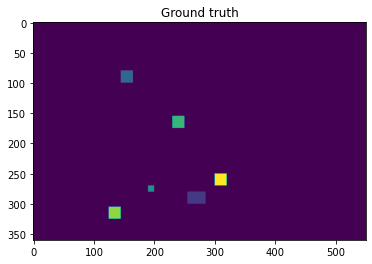

In [78]:
#creating the ground truth image
shape = hyperim.shape
groundtruth = np.zeros([shape[0],shape[1]])
groundtruth[280:300, 255:285] = 1.0   #grass
groundtruth[250:270, 300:320] = 6.0   #dark tree
groundtruth[80:100, 145:165] = 2.0 # asphalt--road-light
groundtruth[270:280, 190:200] = 3.0 # road-dark narrow
groundtruth[155:175,230:250] =4.0 #brown roof
groundtruth[305:325, 125:145] =5.0 #dark roof left


#displaying the ground truth image
plt.figure()
plt.title("Ground truth")
plt.imshow(groundtruth)
plt.show()

Processing...  0.0Processing... 20.0Processing... 40.0Processing... 60.0Processing... 80.0Processing... 100.Processing...done   


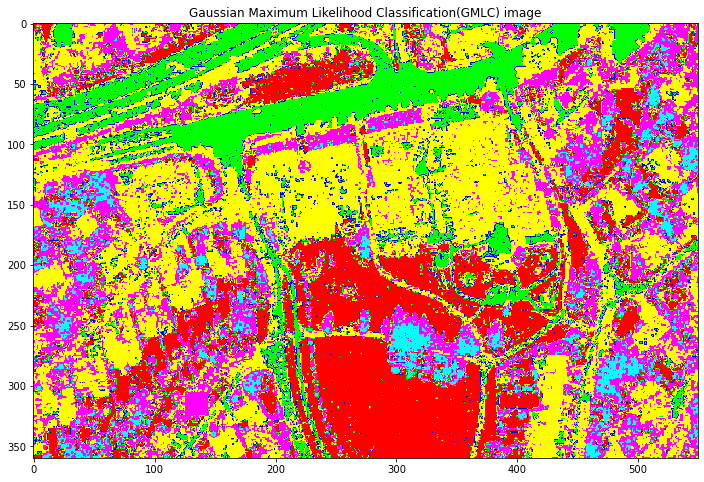

In [79]:
# Gaussian Maximum Likelihood Classification
classes = create_training_classes(hyperim, groundtruth)
gmlc = GaussianClassifier(classes)
clmap = gmlc.classify_image(hyperim)


imshow(classes=clmap, figsize=(12,8))
plt.title("Gaussian Maximum Likelihood Classification(GMLC) image")
plt.show()

### Comment on the GMLC image
- Sucessfully identified the grass, trees, roof tops, and roads present in the image. 
  - The glass has been represented in red color. 
  - The trees have been represented in cyan color. 
  - The Shadows have been represented in Magenta color. 
  - The roads have been represented in lemon color. 
  - The red and concrete roof tops and few of the roads have been represented in yellow color. 

- **Problem:** 
   - Few of the "roof tops", "narrow roads"  have been classified in the same color/group.
   - Few of the housed with red roofs, "grass"  have been classified in the same color/group.   
   - Cannot differentitate between the quality/health state of the vegetation present.

# Task-12 
Which method to determine the amount of vegetation do you think is most appropriate in this hyperspectral image ? Describe why you prefer one method before another.

## Methods for identifing vegetation in the hyperspectral image



#### Method1:  NDVI Image
- All the vegetation of the image is green and rest of the elements of the image is red.
- **Problem:** Cannot differentitate between the quality/health state of the vegetation present.
- **<font color='blue'> 2nd best option** </font>: Vegetation can be easily identified 

#### Method2:  NDVI Thresholded image
- All the vegetation of the image is black and rest of the elements of the image is white.
- **Problem:** 
   - Cannot differentitate between the quality/health state of the vegetation present.
   - Only identified the healthy vegetation because threshold value was set to 0.6 in the question. So, ignoring all the moderate and unhealthy vegetation present in the image.
- **<font color='blue'> 3rd best option** </font>: Vegetation can be easily identified 

#### Method3: PCA Image
- Successfully identifies the vegetation present in the image
- No misidentification / grouping has been detected
- **<font color='blue'> Best option** </font>: Since no problem/misidentification noticed

#### Method4: K-means clustering
- Sucessfully identified the grass, a few roof tops, and roads present in the image for cluster=5. 
- **Problem:** Few of the "dark green vegetation(trees)" has been misclassified as "rooftops".

#### Method5: Gaussian Maximum Likelihood classification
- Sucessfully identified the grass, trees, a few roof tops, and roads present in the image.
- **Problem:** 
   - Few of the "roof tops", "narrow roads"  have been classified in the same color/group.
   - Few of the housed with **red roofs, "grass"**  have been classified in the same color/group.  
   - Cannot differentitate between the quality/health state of the vegetation present.

#### Hence, PCA image is the best option for identifying vegetation present in the given image. Additionally, NDVI Image is the 2nd best option and  the NDVI Thresholded image the 3rd best option.